
# **Deep-Learning Based Human Physical Activity Recognition with Wearable Sensor Data**

The following code implements gender recognition utilising wearable sensor data for multiple activities and sensor placements. This particular example utilises all the six measured signals (accelero x, y, z and gyro x, y, z) and applies end-to-end deep learning, fusing readings from multiple sensors for each activity via a multi-head 1D CNN.

In [ ]:
# Import Libraries
%matplotlib inline
import os
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import scipy.io
import glob
from zipfile import ZipFile
from datetime import datetime
from collections import Counter
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling1D
from keras.layers import Input, Add, Permute, Reshape, multiply
from keras.layers import Concatenate
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
# from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot, image
from scipy import stats
from keras.layers.merge import concatenate
print(tf.__version__)

2.8.0


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/HAR Research Project/Datasets')
!pwd

Mounted at /content/drive
/content/drive/MyDrive/HAR Research Project/Datasets


## Data Ingestion

In [ ]:
# Convert to function
archive_1 = ZipFile('1.zip', 'r')
files_1 = archive_1.namelist()

archive_2 = ZipFile('2.zip', 'r')
files_2 = archive_2.namelist()

archive_3 = ZipFile('3.zip', 'r')
files_3 = archive_3.namelist()

archive_4 = ZipFile('4.zip', 'r')
files_4 = archive_4.namelist()

archive_5 = ZipFile('5.zip', 'r')
files_5 = archive_5.namelist()

archive_6 = ZipFile('6.zip', 'r')
files_6 = archive_6.namelist()

archive_7 = ZipFile('7.zip', 'r')
files_7 = archive_7.namelist()

# Convert to function
dfs_1 = []
for file in files_1[1:]:  #skip .DS_Store
  # print('Reading:', file)
  frame = pd.read_csv(archive_1.open(file), header=None)
  frame['filename'] = os.path.basename(file)
  dfs_1.append(frame)
df_1 = pd.concat(dfs_1,ignore_index=True)
#df_1['activity'] = 1

dfs_2 = []
for file in files_2[1:]:
  # print('Reading:', file)
  frame = pd.read_csv(archive_2.open(file), header=None)
  frame['filename'] = os.path.basename(file)
  dfs_2.append(frame)
df_2 = pd.concat(dfs_2,ignore_index=True)

dfs_3 = []
for file in files_3[1:]:
  # print('Reading:', file)
  frame = pd.read_csv(archive_3.open(file), header=None)
  frame['filename'] = os.path.basename(file)
  dfs_3.append(frame)
df_3 = pd.concat(dfs_3,ignore_index=True)

dfs_4 = []
for file in files_4[1:]:
  # print('Reading:', file)
  frame = pd.read_csv(archive_4.open(file), header=None)
  frame['filename'] = os.path.basename(file)
  dfs_4.append(frame)
df_4 = pd.concat(dfs_4,ignore_index=True)

dfs_5 = []
for file in files_5[1:]:
  # print('Reading:', file)
  frame = pd.read_csv(archive_5.open(file), header=None)
  frame['filename'] = os.path.basename(file)
  dfs_5.append(frame)
df_5 = pd.concat(dfs_5,ignore_index=True)

dfs_6 = []
for file in files_6[1:]:
  # print('Reading:', file)
  frame = pd.read_csv(archive_6.open(file), header=None)
  frame['filename'] = os.path.basename(file)
  dfs_6.append(frame)
df_6 = pd.concat(dfs_6,ignore_index=True)

dfs_7 = []
for file in files_7[1:]:
  # print('Reading:', file)
  frame = pd.read_csv(archive_7.open(file), header=None)
  frame['filename'] = os.path.basename(file)
  dfs_7.append(frame)
df_7 = pd.concat(dfs_7,ignore_index=True)

pdList = [df_1, df_2, df_3, df_4, df_5, df_6, df_7]  # List of your dataframes
raw_df = pd.concat(pdList)

## Data Pre-Processing

In [ ]:
full_df = raw_df.rename(columns={0: 'x_accelero', 1: 'y_accelero', 2: 'z_accelero', 3 : 'x_gyro', 4: 'y_gyro', 5: 'z_gyro'}, errors="raise")
full_df[['activity','subject_name', 'trial_number', 'timestamp', 'sensor_position']] = full_df['filename'].str.split('_',expand=True)
full_df[['sensor_position','file_type']] = full_df['sensor_position'].str.split('.',expand=True)
full_df.drop(columns=['filename', 'file_type'], inplace=True)
gender_df = pd.read_csv('subject_chars_sheet1.csv')
full_gd_df = full_df.merge(gender_df, on='subject_name', how='left')

full_gd_df['x_accelero'] = pd.to_numeric(full_gd_df['x_accelero'])
full_gd_df['y_accelero'] = pd.to_numeric(full_gd_df['y_accelero'])
full_gd_df['z_accelero'] = pd.to_numeric(full_gd_df['z_accelero'])

full_gd_df['x_gyro'] = pd.to_numeric(full_gd_df['x_gyro'])

full_gd_df['y_gyro'] = full_gd_df['y_gyro'].astype('string')
full_gd_df['y_gyro'] = full_gd_df['y_gyro'].apply(lambda x: x[:-2] if x[-2:] == ".1" else x)
full_gd_df['y_gyro'] = pd.to_numeric(full_gd_df['y_gyro'])

full_gd_df['z_gyro'] = full_gd_df['z_gyro'].astype('string')
full_gd_df['z_gyro'] = full_gd_df['z_gyro'].apply(lambda x: x[:-2] if x[-2:] == ".1" else x)
full_gd_df['z_gyro'] = pd.to_numeric(full_gd_df['z_gyro'])

full_gd_df['sensor_position'] = pd.to_numeric(full_gd_df['sensor_position'])
full_gd_df['activity'] = pd.to_numeric(full_gd_df['activity'])
full_gd_df['Gender Code'] = pd.to_numeric(full_gd_df['Gender Code'])

full_gd_df["Subject_Trial_Number"] = full_gd_df["subject_name"] + full_gd_df["trial_number"]
full_gd_df["Subject_Trial_Sensor_Number"] = full_gd_df["subject_name"] + full_gd_df["trial_number"] + full_gd_df["sensor_position"].astype(str)
full_gd_df["Subject_Trial_Sensor_Activity_Number"] = full_gd_df["subject_name"] + full_gd_df["trial_number"] + full_gd_df["sensor_position"].astype(str) + full_gd_df["activity"].astype(str)

# This additional line drops subject records where the data is not given or is incomplete for all trials and sensors. 
# Unlike previous experiments where one subject_trial is left out for 1 sensor at a time, and rest are reshaped and computed, in this experiment sensors are used in parallel
# Leave one out returns the indices, therefore if data is missing for a parallel sensor the method would return an error
full_gd_df = full_gd_df[(full_gd_df.subject_name != 'Cat') & (full_gd_df.subject_name != 'cheryl') & (full_gd_df.subject_name != 'drdang') & (full_gd_df.subject_name != 'gdil') & (full_gd_df.subject_name != 'thanh') & (full_gd_df.subject_name != 'tuong')]
full_gd_df = full_gd_df.reset_index(drop=True)
full_gd_df


,x_accelero,y_accelero,z_accelero,x_gyro,y_gyro,z_gyro,activity,subject_name,trial_number,timestamp,...,Age,Age Group,Gender,Gender Code,Weight,Height,BMI,Subject_Trial_Number,Subject_Trial_Sensor_Number,Subject_Trial_Sensor_Activity_Number
0,-0.995988,-9.761160,-0.081403,-1.251221,2.136230,0.091553,1,amala,1st,1567760697,...,45,3,Female,0,62.7,168.0,22.2,amala1st,amala1st1,amala1st11
1,-1.065420,-9.674969,-0.124498,-0.671387,0.579834,1.220703,1,amala,1st,1567760697,...,45,3,Female,0,62.7,168.0,22.2,amala1st,amala1st1,amala1st11
2,-1.065420,-9.732430,-0.167594,-1.678467,-0.610352,0.732422,1,amala,1st,1567760697,...,45,3,Female,0,62.7,168.0,22.2,amala1st,amala1st1,amala1st11
3,-1.079785,-9.758766,-0.102951,-1.159668,0.305176,0.183105,1,amala,1st,1567760697,...,45,3,Female,0,62.7,168.0,22.2,amala1st,amala1st1,amala1st11
4,-1.082179,-9.773131,-0.213084,-0.183105,0.000000,-0.152588,1,amala,1st,1567760697,...,45,3,Female,0,62.7,168.0,22.2,amala1st,amala1st1,amala1st11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4099528,-0.217872,-9.279926,-1.654393,-2.685547,5.126953,-1.892090,7,van,3rd,1566546471,...,36,2,Male,1,79.0,173.0,26.4,van3rd,van3rd5,van3rd57
4099529,0.196325,-9.339781,-1.697489,-4.241943,-0.488281,-0.335693,7,van,3rd,1566546471,...,36,2,Male,1,79.0,173.0,26.4,van3rd,van3rd5,van3rd57
4099530,0.548272,-9.232042,-1.563414,-4.608154,-0.976562,2.197266,7,van,3rd,1566546471,...,36,2,Male,1,79.0,173.0,26.4,van3rd,van3rd5,van3rd57
4099531,0.591368,-9.188946,-1.699883,-4.943848,-0.061035,5.218506,7,van,3rd,1566546471,...,36,2,Male,1,79.0,173.0,26.4,van3rd,van3rd5,van3rd57


In [ ]:
# the following code ensures all sensors have the same timesteps, before LOGO is called

dfs =[]
#activity_list = ['amala1st11', 'amala1st12']
activity_list = set(full_gd_df.Subject_Trial_Sensor_Activity_Number)
for activity in activity_list:
  partial_df = full_gd_df[full_gd_df.Subject_Trial_Sensor_Activity_Number == activity]
  df_0 = pd.DataFrame([0]*(3000- partial_df.shape[0]))
  df = partial_df.append(df_0, ignore_index=True)
  for column in ['Gender', 'Gender Code', 'Subject_Trial_Number', 'Subject_Trial_Sensor_Activity_Number', 'Subject_Trial_Sensor_Number', 
                 'activity', 'sensor_position', 'subject_name', 'trial_number']:
                 df[column].fillna(df[column].mode()[0], inplace=True)
  df=df.replace(np.nan,0)
  dfs.append(df)
final_df = pd.concat(dfs,ignore_index=True)
final_df = final_df.reset_index(drop=True)
final_df

,0,Age,Age Group,BMI,Gender,Gender Code,Height,Subject_Trial_Number,Subject_Trial_Sensor_Activity_Number,Subject_Trial_Sensor_Number,...,sensor_position,subject_name,timestamp,trial_number,x_accelero,x_gyro,y_accelero,y_gyro,z_accelero,z_gyro
0,0.0,26.0,1.0,23.1,Male,1.0,173.0,lahiru1st,lahiru1st41,lahiru1st4,...,4.0,lahiru,1565334603,1st,-0.849942,0.396729,-9.114726,0.762939,-2.319981,1.403809
1,0.0,26.0,1.0,23.1,Male,1.0,173.0,lahiru1st,lahiru1st41,lahiru1st4,...,4.0,lahiru,1565334603,1st,-1.055843,-0.946045,-9.131485,-0.213623,-2.260126,-0.366211
2,0.0,26.0,1.0,23.1,Male,1.0,173.0,lahiru1st,lahiru1st41,lahiru1st4,...,4.0,lahiru,1565334603,1st,-1.046266,-0.427246,-9.162610,0.793457,-2.176329,0.274658
3,0.0,26.0,1.0,23.1,Male,1.0,173.0,lahiru1st,lahiru1st41,lahiru1st4,...,4.0,lahiru,1565334603,1st,-1.067814,-0.030518,-9.143456,1.861572,-2.121263,0.518799
4,0.0,26.0,1.0,23.1,Male,1.0,173.0,lahiru1st,lahiru1st41,lahiru1st4,...,4.0,lahiru,1565334603,1st,-1.077391,0.000000,-9.119514,2.288818,-2.214637,0.518799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10079995,0.0,0.0,0.0,0.0,Female,0.0,0.0,drshang3rd,drshang3rd46,drshang3rd4,...,4.0,drshang,0,3rd,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10079996,0.0,0.0,0.0,0.0,Female,0.0,0.0,drshang3rd,drshang3rd46,drshang3rd4,...,4.0,drshang,0,3rd,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10079997,0.0,0.0,0.0,0.0,Female,0.0,0.0,drshang3rd,drshang3rd46,drshang3rd4,...,4.0,drshang,0,3rd,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10079998,0.0,0.0,0.0,0.0,Female,0.0,0.0,drshang3rd,drshang3rd46,drshang3rd4,...,4.0,drshang,0,3rd,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
final_df.to_csv('final_df.csv')

## Function Definition

In [ ]:
# Adding learning rate scheduler to optimise above Deep Forward Neural Network

# This function keeps the initial learning rate for the first ten epochs and decreases it exponentially after that.
def scheduler(epoch, lr):
   if epoch < 10:
     return lr
   else:
     return lr * tf.math.exp(-0.1)

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler) # call learning rate scheduler

In [ ]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

### Model Architecture

In [ ]:
partial_df = final_df.drop(columns=[0, 
                                  'subject_name', 'trial_number','timestamp', 
                                  'Age', 'Age Group', 'Gender', 'Weight', 'Height', 'BMI',
                                  'Subject_Trial_Sensor_Activity_Number', 'Subject_Trial_Sensor_Number']) #DROP MORE COLUMNS
le = preprocessing.LabelEncoder()
partial_df['Subject_Trial_Number_Encoded'] = le.fit_transform(partial_df['Subject_Trial_Number'])
partial_df = partial_df.drop(columns=['Subject_Trial_Number'])
partial_df_original = partial_df[partial_df["activity"] == 6]

#-------------------------------------------------------------------------------------------

# Get data for sensor 1
partial_df = partial_df_original[partial_df_original["sensor_position"] == 1]
partial_df = partial_df.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

# Standardise
scaler = StandardScaler()
partial_df[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']])

# Partition Train and Test Data
partial_df_train = partial_df[partial_df['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
partial_df_test = partial_df[partial_df['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

# Define TRAIN X and y variables
X_TRAIN = partial_df_train[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']]
y_TRAIN = partial_df_train['Gender Code']
X_TRAIN = X_TRAIN.to_numpy() # for LOGO
y_TRAIN = y_TRAIN.to_numpy() # for LOGO

#-------------------------------------------------------------------------------------------

# Get data for sensor 2
partial_df_2 = partial_df_original[partial_df_original["sensor_position"] == 3]
partial_df_2 = partial_df_2.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

# Standardise
scaler = StandardScaler()
partial_df_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']])

# Partition Train and Test Data
partial_df_train_2 = partial_df_2[partial_df_2['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
partial_df_test_2 = partial_df_2[partial_df_2['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

# Define TRAIN X and y variables
X_TRAIN_2 = partial_df_train_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']]
y_TRAIN_2 = partial_df_train_2['Gender Code']
X_TRAIN_2 = X_TRAIN_2.to_numpy() # for LOGO
y_TRAIN_2 = y_TRAIN_2.to_numpy() # for LOGO

# Both sensor 1 and 2 train sets should have same indices that can be referenced by logo
#-------------------------------------------------------------------------------------------

# Define TEST X and y variables
X_TEST = partial_df_test[['x_accelero', 'y_accelero', 'z_accelero','x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']].reset_index(drop=True)
y_TEST = partial_df_test['Gender Code'].reset_index(drop=True)

reshaped_X_test, reshaped_y_test = get_frames(X_TEST, y_TEST) # convert test data to frames

#-------------------------------------------------------------------------------------------

# Define TEST X and y variables
X_TEST_2 = partial_df_test_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']].reset_index(drop=True)
y_TEST_2 = partial_df_test_2['Gender Code'].reset_index(drop=True)

reshaped_X_test_2, reshaped_y_test_2 = get_frames(X_TEST_2, y_TEST_2) # convert test data to frames

#-------------------------------------------------------------------------------------------

groups = partial_df_train['Subject_Trial_Number_Encoded']
logo = LeaveOneGroupOut()
split_number = logo.get_n_splits(X_TRAIN, y_TRAIN, groups)
groups = groups.to_numpy()

#-------------------------------------------------------------------------------------------

acc_per_fold = []
loss_per_fold = []
# data for the confusion matrix
cm_holder_per_fold = []
# create empty lists for later
y_true, y_pred = list(), list()

for train_ix, val_ix in logo.split(X_TRAIN, y_TRAIN, groups):
    # split data
    X_train, X_val = X_TRAIN[train_ix, :], X_TRAIN[val_ix, :]
    y_train, y_val = y_TRAIN[train_ix], y_TRAIN[val_ix] 

    X_train = pd.DataFrame(data = X_train, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
    X_val = pd.DataFrame(data = X_val, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
    y_train = pd.DataFrame(data = y_train)
    y_val = pd.DataFrame(data = y_val) 

    reshaped_X_train, reshaped_y_train = get_frames(X_train, y_train) 
    reshaped_X_val, reshaped_y_val = get_frames(X_val, y_val) 

    #-------------------------------------------------------------------------------------------

    # split data
    X_train_2, X_val_2 = X_TRAIN_2[train_ix, :], X_TRAIN_2[val_ix, :]
    y_train_2, y_val_2 = y_TRAIN_2[train_ix], y_TRAIN_2[val_ix] 

    X_train_2 = pd.DataFrame(data = X_train_2, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
    X_val_2 = pd.DataFrame(data = X_val_2, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
    y_train_2 = pd.DataFrame(data = y_train_2)
    y_val_2 = pd.DataFrame(data = y_val_2) 

    reshaped_X_train_2, reshaped_y_train_2 = get_frames(X_train_2, y_train_2) 
    reshaped_X_val_2, reshaped_y_val_2 = get_frames(X_val_2, y_val_2) 

    #-------------------------------------------------------------------------------------------
    
    # defining some input variables
    n_timesteps, n_features, n_outputs = reshaped_X_train.shape[1], reshaped_X_val.shape[2], reshaped_y_train.shape[1]

    # getting the model
    model = cnn_model_creation(n_timesteps, n_features)

    # getting the model
    model = cnn_model_creation(n_timesteps, n_features)
    #model.summary()
    #plot_model(model, to_file='model_plot_3.png', show_shapes=True, show_layer_names=True)  
    # fit model
    history = model.fit([reshaped_X_train,reshaped_X_train_2], reshaped_y_train,
              epochs=100,
              verbose=0,
              callbacks=[lr_callback],
              validation_data=([reshaped_X_val,reshaped_X_val_2], reshaped_y_val)) # Chnage number of epochs!
    
    test_scores = model.evaluate([reshaped_X_test, reshaped_X_test_2],reshaped_y_test, verbose=0)
    acc_per_fold.append(test_scores[1] * 100)
    loss_per_fold.append(test_scores[0])
    
    # Use the model to predict the values from the test data.
    predictions_ = model.predict([reshaped_X_test, reshaped_X_test_2])
    # Take the class with the highest probability from the test predictions
    predictions = np.where(predictions_ > 0.5, 1, 0)
    y_pred.append(predictions)
    # Calculate the confusion matrix using sklearn.metrics
    cm = metrics.confusion_matrix(reshaped_y_test, predictions)
    
    # append the confusion matrix of this fold
    cm_holder_per_fold.append(cm)

    # store ground truth and predicted values
    y_true.append(reshaped_y_test) #[0])
    y_pred.append(predictions) #[0])

class_names = ['0', '1']

# confusion matrix per fold
sum_cm_holder_per_fold = []
cm_shape = np.array([len(class_names),len(class_names)])
for k in range(len(cm_holder_per_fold)):
    cm_mask = np.zeros(cm_shape)
    cm_mask[:cm_holder_per_fold[k].shape[0], :cm_holder_per_fold[k].shape[1]] = cm_holder_per_fold[k]
    sum_cm_holder_per_fold.append(cm_mask)

sum_cm_per_fold = sum(sum_cm_holder_per_fold)
figure = plot_confusion_matrix(sum_cm_per_fold, class_names=class_names)
plt.show()  

mean_accuracy = np.mean(acc_per_fold)
mean_std = np.std(acc_per_fold)
mean_loss = np.mean(loss_per_fold)
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

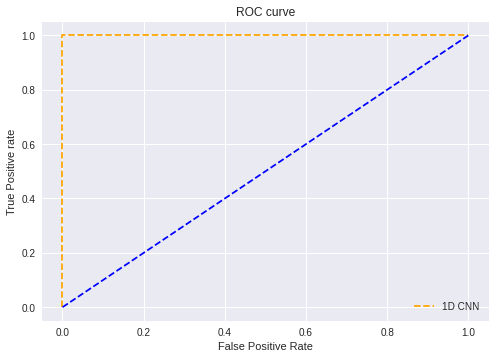

In [ ]:
from sklearn.metrics import roc_curve
fpr1, tpr1, thresh1 = roc_curve(reshaped_y_test, predictions_, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(reshaped_y_test))]
p_fpr, p_tpr, _ = roc_curve(reshaped_y_test, random_probs, pos_label=1)

# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='1D CNN')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

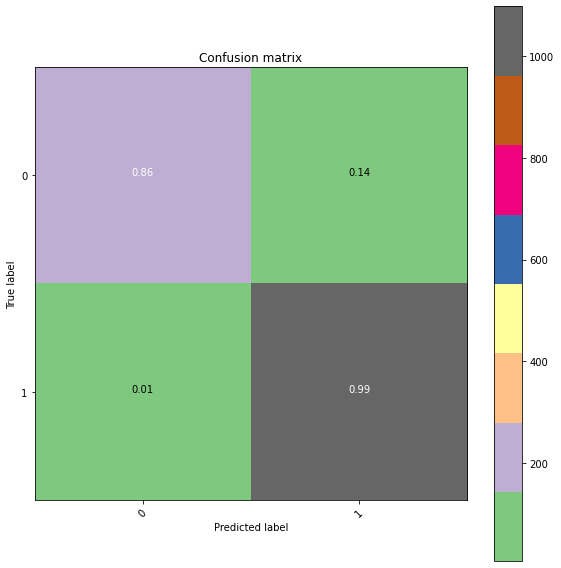

> Accuracy: 96.87267330628407 (+- 5.907276928702619)
> Loss: 1.6667228967328616


In [ ]:
partial_df = final_df.drop(columns=[0, 
                                  'subject_name', 'trial_number','timestamp', 
                                  'Age', 'Age Group', 'Gender', 'Weight', 'Height', 'BMI',
                                  'Subject_Trial_Sensor_Activity_Number', 'Subject_Trial_Sensor_Number']) #DROP MORE COLUMNS
le = preprocessing.LabelEncoder()
partial_df['Subject_Trial_Number_Encoded'] = le.fit_transform(partial_df['Subject_Trial_Number'])
partial_df = partial_df.drop(columns=['Subject_Trial_Number'])
partial_df_original = partial_df[partial_df["activity"] == 6]

#-------------------------------------------------------------------------------------------

# Get data for sensor 1
partial_df = partial_df_original[partial_df_original["sensor_position"] == 1]
partial_df = partial_df.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

# Standardise
scaler = StandardScaler()
partial_df[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']])

# Partition Train and Test Data
partial_df_train = partial_df[partial_df['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
partial_df_test = partial_df[partial_df['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

# Define TRAIN X and y variables
X_TRAIN = partial_df_train[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']]
y_TRAIN = partial_df_train['Gender Code']
X_TRAIN = X_TRAIN.to_numpy() # for LOGO
y_TRAIN = y_TRAIN.to_numpy() # for LOGO

#-------------------------------------------------------------------------------------------

# Get data for sensor 2
partial_df_2 = partial_df_original[partial_df_original["sensor_position"] == 3]
partial_df_2 = partial_df_2.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

# Standardise
scaler = StandardScaler()
partial_df_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']])

# Partition Train and Test Data
partial_df_train_2 = partial_df_2[partial_df_2['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
partial_df_test_2 = partial_df_2[partial_df_2['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

# Define TRAIN X and y variables
X_TRAIN_2 = partial_df_train_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']]
y_TRAIN_2 = partial_df_train_2['Gender Code']
X_TRAIN_2 = X_TRAIN_2.to_numpy() # for LOGO
y_TRAIN_2 = y_TRAIN_2.to_numpy() # for LOGO

# Both sensor 1 and 2 train sets should have same indices that can be referenced by logo
#-------------------------------------------------------------------------------------------

# Define TEST X and y variables
X_TEST = partial_df_test[['x_accelero', 'y_accelero', 'z_accelero','x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']].reset_index(drop=True)
y_TEST = partial_df_test['Gender Code'].reset_index(drop=True)

reshaped_X_test, reshaped_y_test = get_frames(X_TEST, y_TEST) # convert test data to frames

#-------------------------------------------------------------------------------------------

# Define TEST X and y variables
X_TEST_2 = partial_df_test_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']].reset_index(drop=True)
y_TEST_2 = partial_df_test_2['Gender Code'].reset_index(drop=True)

reshaped_X_test_2, reshaped_y_test_2 = get_frames(X_TEST_2, y_TEST_2) # convert test data to frames

#-------------------------------------------------------------------------------------------

groups = partial_df_train['Subject_Trial_Number_Encoded']
logo = LeaveOneGroupOut()
split_number = logo.get_n_splits(X_TRAIN, y_TRAIN, groups)
groups = groups.to_numpy()

#-------------------------------------------------------------------------------------------

acc_per_fold = []
loss_per_fold = []
# data for the confusion matrix
cm_holder_per_fold = []
# create empty lists for later
y_true, y_pred = list(), list()

for train_ix, val_ix in logo.split(X_TRAIN, y_TRAIN, groups):
    # split data
    X_train, X_val = X_TRAIN[train_ix, :], X_TRAIN[val_ix, :]
    y_train, y_val = y_TRAIN[train_ix], y_TRAIN[val_ix] 

    X_train = pd.DataFrame(data = X_train, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
    X_val = pd.DataFrame(data = X_val, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
    y_train = pd.DataFrame(data = y_train)
    y_val = pd.DataFrame(data = y_val) 

    reshaped_X_train, reshaped_y_train = get_frames(X_train, y_train) 
    reshaped_X_val, reshaped_y_val = get_frames(X_val, y_val) 

    #-------------------------------------------------------------------------------------------

    # split data
    X_train_2, X_val_2 = X_TRAIN_2[train_ix, :], X_TRAIN_2[val_ix, :]
    y_train_2, y_val_2 = y_TRAIN_2[train_ix], y_TRAIN_2[val_ix] 

    X_train_2 = pd.DataFrame(data = X_train_2, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
    X_val_2 = pd.DataFrame(data = X_val_2, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
    y_train_2 = pd.DataFrame(data = y_train_2)
    y_val_2 = pd.DataFrame(data = y_val_2) 

    reshaped_X_train_2, reshaped_y_train_2 = get_frames(X_train_2, y_train_2) 
    reshaped_X_val_2, reshaped_y_val_2 = get_frames(X_val_2, y_val_2) 

    #-------------------------------------------------------------------------------------------
    
    # defining some input variables
    n_timesteps, n_features, n_outputs = reshaped_X_train.shape[1], reshaped_X_val.shape[2], reshaped_y_train.shape[1]

    # getting the model
    model = cnn_model_creation(n_timesteps, n_features)

    # getting the model
    model = cnn_model_creation(n_timesteps, n_features)
    #model.summary()
    #plot_model(model, to_file='model_plot_3.png', show_shapes=True, show_layer_names=True)  
    # fit model
    history = model.fit([reshaped_X_train,reshaped_X_train_2], reshaped_y_train,
              epochs=100,
              verbose=0,
              callbacks=[lr_callback],
              validation_data=([reshaped_X_val,reshaped_X_val_2], reshaped_y_val)) # Chnage number of epochs!
    
    test_scores = model.evaluate([reshaped_X_test, reshaped_X_test_2],reshaped_y_test, verbose=0)
    acc_per_fold.append(test_scores[1] * 100)
    loss_per_fold.append(test_scores[0])
    
    # Use the model to predict the values from the test data.
    predictions_ = model.predict([reshaped_X_test, reshaped_X_test_2])
    # Take the class with the highest probability from the test predictions
    predictions = np.where(predictions_ > 0.5, 1, 0)
    y_pred.append(predictions)
    # Calculate the confusion matrix using sklearn.metrics
    cm = metrics.confusion_matrix(reshaped_y_test, predictions)
    
    # append the confusion matrix of this fold
    cm_holder_per_fold.append(cm)

    # store ground truth and predicted values
    y_true.append(reshaped_y_test[0])
    y_pred.append(predictions[0])

class_names = ['0', '1']

# confusion matrix per fold
sum_cm_holder_per_fold = []
cm_shape = np.array([len(class_names),len(class_names)])
for k in range(len(cm_holder_per_fold)):
    cm_mask = np.zeros(cm_shape)
    cm_mask[:cm_holder_per_fold[k].shape[0], :cm_holder_per_fold[k].shape[1]] = cm_holder_per_fold[k]
    sum_cm_holder_per_fold.append(cm_mask)

sum_cm_per_fold = sum(sum_cm_holder_per_fold)
figure = plot_confusion_matrix(sum_cm_per_fold, class_names=class_names)
plt.show()  

mean_accuracy = np.mean(acc_per_fold)
mean_std = np.std(acc_per_fold)
mean_loss = np.mean(loss_per_fold)
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

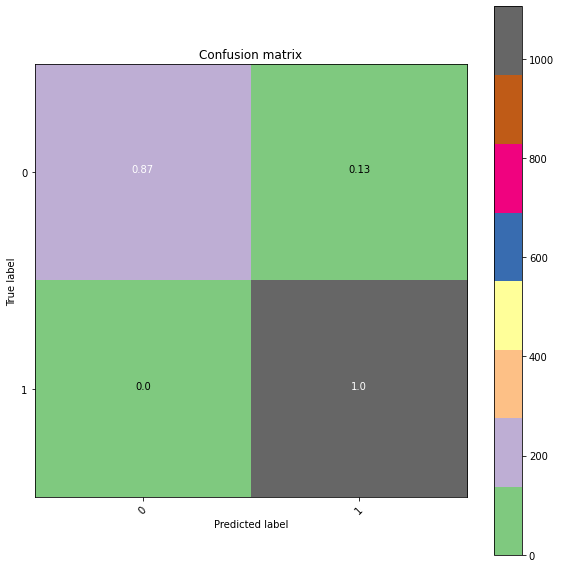

> Accuracy: 97.76619521877434 (+- 4.614127315394931)
> Loss: 0.4004818095436579


In [ ]:
partial_df = final_df.drop(columns=[0, 
                                  'subject_name', 'trial_number','timestamp', 
                                  'Age', 'Age Group', 'Gender', 'Weight', 'Height', 'BMI',
                                  'Subject_Trial_Sensor_Activity_Number', 'Subject_Trial_Sensor_Number']) #DROP MORE COLUMNS
le = preprocessing.LabelEncoder()
partial_df['Subject_Trial_Number_Encoded'] = le.fit_transform(partial_df['Subject_Trial_Number'])
partial_df = partial_df.drop(columns=['Subject_Trial_Number'])
partial_df_original = partial_df[partial_df["activity"] == 6]

#-------------------------------------------------------------------------------------------

# Get data for sensor 1
partial_df = partial_df_original[partial_df_original["sensor_position"] == 1]
partial_df = partial_df.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

# Standardise
scaler = StandardScaler()
partial_df[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']])

# Partition Train and Test Data
partial_df_train = partial_df[partial_df['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
partial_df_test = partial_df[partial_df['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

# Define TRAIN X and y variables
X_TRAIN = partial_df_train[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']]
y_TRAIN = partial_df_train['Gender Code']
X_TRAIN = X_TRAIN.to_numpy() # for LOGO
y_TRAIN = y_TRAIN.to_numpy() # for LOGO

#-------------------------------------------------------------------------------------------

# Get data for sensor 2
partial_df_2 = partial_df_original[partial_df_original["sensor_position"] == 3]
partial_df_2 = partial_df_2.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

# Standardise
scaler = StandardScaler()
partial_df_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']])

# Partition Train and Test Data
partial_df_train_2 = partial_df_2[partial_df_2['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
partial_df_test_2 = partial_df_2[partial_df_2['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

# Define TRAIN X and y variables
X_TRAIN_2 = partial_df_train_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']]
y_TRAIN_2 = partial_df_train_2['Gender Code']
X_TRAIN_2 = X_TRAIN_2.to_numpy() # for LOGO
y_TRAIN_2 = y_TRAIN_2.to_numpy() # for LOGO

# Both sensor 1 and 2 train sets should have same indices that can be referenced by logo
#-------------------------------------------------------------------------------------------

# Define TEST X and y variables
X_TEST = partial_df_test[['x_accelero', 'y_accelero', 'z_accelero','x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']].reset_index(drop=True)
y_TEST = partial_df_test['Gender Code'].reset_index(drop=True)

reshaped_X_test, reshaped_y_test = get_frames(X_TEST, y_TEST) # convert test data to frames

#-------------------------------------------------------------------------------------------

# Define TEST X and y variables
X_TEST_2 = partial_df_test_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']].reset_index(drop=True)
y_TEST_2 = partial_df_test_2['Gender Code'].reset_index(drop=True)

reshaped_X_test_2, reshaped_y_test_2 = get_frames(X_TEST_2, y_TEST_2) # convert test data to frames

#-------------------------------------------------------------------------------------------

groups = partial_df_train['Subject_Trial_Number_Encoded']
logo = LeaveOneGroupOut()
split_number = logo.get_n_splits(X_TRAIN, y_TRAIN, groups)
groups = groups.to_numpy()

#-------------------------------------------------------------------------------------------

acc_per_fold = []
loss_per_fold = []
# data for the confusion matrix
cm_holder_per_fold = []
# create empty lists for later
y_true, y_pred = list(), list()

for train_ix, val_ix in logo.split(X_TRAIN, y_TRAIN, groups):
    # split data
    X_train, X_val = X_TRAIN[train_ix, :], X_TRAIN[val_ix, :]
    y_train, y_val = y_TRAIN[train_ix], y_TRAIN[val_ix] 

    X_train = pd.DataFrame(data = X_train, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
    X_val = pd.DataFrame(data = X_val, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
    y_train = pd.DataFrame(data = y_train)
    y_val = pd.DataFrame(data = y_val) 

    reshaped_X_train, reshaped_y_train = get_frames(X_train, y_train) 
    reshaped_X_val, reshaped_y_val = get_frames(X_val, y_val) 

    #-------------------------------------------------------------------------------------------

    # split data
    X_train_2, X_val_2 = X_TRAIN_2[train_ix, :], X_TRAIN_2[val_ix, :]
    y_train_2, y_val_2 = y_TRAIN_2[train_ix], y_TRAIN_2[val_ix] 

    X_train_2 = pd.DataFrame(data = X_train_2, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
    X_val_2 = pd.DataFrame(data = X_val_2, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
    y_train_2 = pd.DataFrame(data = y_train_2)
    y_val_2 = pd.DataFrame(data = y_val_2) 

    reshaped_X_train_2, reshaped_y_train_2 = get_frames(X_train_2, y_train_2) 
    reshaped_X_val_2, reshaped_y_val_2 = get_frames(X_val_2, y_val_2) 

    #-------------------------------------------------------------------------------------------
    
    # defining some input variables
    n_timesteps, n_features, n_outputs = reshaped_X_train.shape[1], reshaped_X_val.shape[2], reshaped_y_train.shape[1]

    # getting the model
    model = cnn_model_creation(n_timesteps, n_features)

    # getting the model
    model = cnn_model_creation(n_timesteps, n_features)
    #model.summary()
    #plot_model(model, to_file='model_plot_3.png', show_shapes=True, show_layer_names=True)  
    # fit model
    history = model.fit([reshaped_X_train,reshaped_X_train_2], reshaped_y_train,
              epochs=100,
              verbose=0,
              callbacks=[lr_callback],
              validation_data=([reshaped_X_val,reshaped_X_val_2], reshaped_y_val)) # Chnage number of epochs!
    
    test_scores = model.evaluate([reshaped_X_test, reshaped_X_test_2],reshaped_y_test, verbose=0)
    acc_per_fold.append(test_scores[1] * 100)
    loss_per_fold.append(test_scores[0])
    
    # Use the model to predict the values from the test data.
    predictions_ = model.predict([reshaped_X_test, reshaped_X_test_2])
    # Take the class with the highest probability from the test predictions
    predictions = np.where(predictions_ > 0.5, 1, 0)
    y_pred.append(predictions)
    # Calculate the confusion matrix using sklearn.metrics
    cm = metrics.confusion_matrix(reshaped_y_test, predictions)
    
    # append the confusion matrix of this fold
    cm_holder_per_fold.append(cm)

    # store ground truth and predicted values
    y_true.append(reshaped_y_test[0])
    y_pred.append(predictions[0])

class_names = ['0', '1']

# confusion matrix per fold
sum_cm_holder_per_fold = []
cm_shape = np.array([len(class_names),len(class_names)])
for k in range(len(cm_holder_per_fold)):
    cm_mask = np.zeros(cm_shape)
    cm_mask[:cm_holder_per_fold[k].shape[0], :cm_holder_per_fold[k].shape[1]] = cm_holder_per_fold[k]
    sum_cm_holder_per_fold.append(cm_mask)

sum_cm_per_fold = sum(sum_cm_holder_per_fold)
figure = plot_confusion_matrix(sum_cm_per_fold, class_names=class_names)
plt.show()  

mean_accuracy = np.mean(acc_per_fold)
mean_std = np.std(acc_per_fold)
mean_loss = np.mean(loss_per_fold)
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

## 2 Parallel Sensors 

In [ ]:
# Multi-headed 1D CNN
def cnn_model_creation(n_timesteps, n_features):
    # head 1
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs1) #change kernel size to 5 
    bn1 = BatchNormalization()(conv1)
    pool1 = GlobalAveragePooling1D()(bn1) 
    flat1 = Flatten()(pool1)

    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs2)
    bn2 = BatchNormalization()(conv2)
    pool2 = GlobalAveragePooling1D()(bn2)
    flat2 = Flatten()(pool2)

    # merge
    merged = concatenate([flat1, flat2])

    # interpretation
    dense1 = Dense(16, activation='relu', kernel_regularizer='l2')(merged) #16
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    # save a plot of the model
    # plot_model(model, show_shapes=True, to_file='multichannel.png')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

#GlobalAveragePooling1D - check results after changing to this!! *CHECK* #MaxPooling1D(pool_size=2)

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

def get_frames(X, Y):
  
  N_FEATURES = 6

  frames = []
  labels = []
  for Subject_Trial_Number_Encoded in set(X.Subject_Trial_Number_Encoded):  #for each group
    current_frame = X.loc[X.Subject_Trial_Number_Encoded == Subject_Trial_Number_Encoded]  #get the all the frames for that group
    start_index = min(current_frame.index)
    end_index = max(current_frame.index) + 1
    frame_size = len(current_frame)

    ax = X['x_accelero'].values[start_index: end_index] 
    ay = X['y_accelero'].values[start_index: end_index]
    az = X['z_accelero'].values[start_index: end_index]
    gx = X['x_gyro'].values[start_index: end_index] 
    gy = X['y_gyro'].values[start_index: end_index]
    gz = X['z_gyro'].values[start_index: end_index]

    # Retrieve the most often used label in this segment
    label = stats.mode(Y[start_index: end_index])[0][0]
    
    frames.append([ax, ay, az, gx, gy, gz])
    labels.append(label)
  # returns frames of samples, each sample(group) with three features, each feature with n timesteps 28*3*1729 i.e. groups/samples * features * timesteps

  # As the frame size differes for each group, the frames are padded
  padded_frames = []
  for row in frames:
    shape = np.shape(row)
    padded_array = np.zeros((6, 3000)) 
    padded_array[:shape[0],:shape[1]] = row
    padded_frames.append(padded_array)

  # return exactly the same shape as above but padded so each group has same number of steps - might not need this for this experiment! *CHECK*

  # Bring the segments into a better shape
  reshaped_padded_frames = np.transpose(padded_frames, (0, 2, 1))
  reshaped_labels = np.asarray(labels)
  
  # finally converts the  28*3*1729  -> 28*1729*3 i.e. groups/samples * timestep * features
  return reshaped_padded_frames, reshaped_labels

In [ ]:
def get_scores(sensor_position_number, activity_number, full_gd_df): 

  partial_df = final_df.drop(columns=[0, 
                                    'subject_name', 'trial_number','timestamp', 
                                    'Age', 'Age Group', 'Gender', 'Weight', 'Height', 'BMI',
                                    'Subject_Trial_Sensor_Activity_Number', 'Subject_Trial_Sensor_Number']) #DROP MORE COLUMNS
  le = preprocessing.LabelEncoder()
  partial_df['Subject_Trial_Number_Encoded'] = le.fit_transform(partial_df['Subject_Trial_Number'])
  partial_df = partial_df.drop(columns=['Subject_Trial_Number'])
  partial_df_original = partial_df[partial_df["activity"] == activity_number]

  #-------------------------------------------------------------------------------------------

  # Get data for sensor 1
  partial_df = partial_df_original[partial_df_original["sensor_position"] == sensor_position_number[0]]
  partial_df = partial_df.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

  # Standardise
  scaler = StandardScaler()
  partial_df[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']])

  # Partition Train and Test Data
  partial_df_train = partial_df[partial_df['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
  partial_df_test = partial_df[partial_df['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

  # Define TRAIN X and y variables
  X_TRAIN = partial_df_train[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']]
  y_TRAIN = partial_df_train['Gender Code']
  X_TRAIN = X_TRAIN.to_numpy() # for LOGO
  y_TRAIN = y_TRAIN.to_numpy() # for LOGO

  #-------------------------------------------------------------------------------------------

  # Get data for sensor 2
  partial_df_2 = partial_df_original[partial_df_original["sensor_position"] == sensor_position_number[1]]
  partial_df_2 = partial_df_2.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

  # Standardise
  scaler = StandardScaler()
  partial_df_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']])

  # Partition Train and Test Data
  partial_df_train_2 = partial_df_2[partial_df_2['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
  partial_df_test_2 = partial_df_2[partial_df_2['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

  # Define TRAIN X and y variables
  X_TRAIN_2 = partial_df_train_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']]
  y_TRAIN_2 = partial_df_train_2['Gender Code']
  X_TRAIN_2 = X_TRAIN_2.to_numpy() # for LOGO
  y_TRAIN_2 = y_TRAIN_2.to_numpy() # for LOGO

  # Both sensor 1 and 2 train sets should have same indices that can be referenced by logo
  #-------------------------------------------------------------------------------------------

  # Define TEST X and y variables
  X_TEST = partial_df_test[['x_accelero', 'y_accelero', 'z_accelero','x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']].reset_index(drop=True)
  y_TEST = partial_df_test['Gender Code'].reset_index(drop=True)

  reshaped_X_test, reshaped_y_test = get_frames(X_TEST, y_TEST) # convert test data to frames

  #-------------------------------------------------------------------------------------------

  # Define TEST X and y variables
  X_TEST_2 = partial_df_test_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']].reset_index(drop=True)
  y_TEST_2 = partial_df_test_2['Gender Code'].reset_index(drop=True)

  reshaped_X_test_2, reshaped_y_test_2 = get_frames(X_TEST_2, y_TEST_2) # convert test data to frames
  
  #-------------------------------------------------------------------------------------------

  groups = partial_df_train['Subject_Trial_Number_Encoded']
  logo = LeaveOneGroupOut()
  split_number = logo.get_n_splits(X_TRAIN, y_TRAIN, groups)
  groups = groups.to_numpy()

  #-------------------------------------------------------------------------------------------

  acc_per_fold = []
  loss_per_fold = []

  for train_ix, val_ix in logo.split(X_TRAIN, y_TRAIN, groups):
      # split data
      X_train, X_val = X_TRAIN[train_ix, :], X_TRAIN[val_ix, :]
      y_train, y_val = y_TRAIN[train_ix], y_TRAIN[val_ix] 

      X_train = pd.DataFrame(data = X_train, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      X_val = pd.DataFrame(data = X_val, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      y_train = pd.DataFrame(data = y_train)
      y_val = pd.DataFrame(data = y_val) 

      reshaped_X_train, reshaped_y_train = get_frames(X_train, y_train) 
      reshaped_X_val, reshaped_y_val = get_frames(X_val, y_val) 

      #-------------------------------------------------------------------------------------------

      # split data
      X_train_2, X_val_2 = X_TRAIN_2[train_ix, :], X_TRAIN_2[val_ix, :]
      y_train_2, y_val_2 = y_TRAIN_2[train_ix], y_TRAIN_2[val_ix] 

      X_train_2 = pd.DataFrame(data = X_train_2, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      X_val_2 = pd.DataFrame(data = X_val_2, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      y_train_2 = pd.DataFrame(data = y_train_2)
      y_val_2 = pd.DataFrame(data = y_val_2) 

      reshaped_X_train_2, reshaped_y_train_2 = get_frames(X_train_2, y_train_2) 
      reshaped_X_val_2, reshaped_y_val_2 = get_frames(X_val_2, y_val_2) 

      #-------------------------------------------------------------------------------------------
      
      # defining some input variables
      n_timesteps, n_features, n_outputs = reshaped_X_train.shape[1], reshaped_X_val.shape[2], reshaped_y_train.shape[1]

      # getting the model
      model = cnn_model_creation(n_timesteps, n_features)

      # fit model
      history = model.fit([reshaped_X_train,reshaped_X_train_2], reshaped_y_train,
                epochs=50,
                verbose=0,
                callbacks=[lr_callback],
                validation_data=([reshaped_X_val,reshaped_X_val_2], reshaped_y_val)) # Chnage number of epochs!
      
      test_scores = model.evaluate([reshaped_X_test, reshaped_X_test_2],reshaped_y_test, verbose=0)
      acc_per_fold.append(test_scores[1] * 100)
      loss_per_fold.append(test_scores[0])
  mean_accuracy = np.mean(acc_per_fold)
  mean_std = np.std(acc_per_fold)
  mean_loss = np.mean(loss_per_fold)
  print('Sensor:', sensor_position_number, 'Activity:', activity_number)
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  return mean_accuracy

In [ ]:
test_scores = []
activity_list = [6, 7]
sensor_list = [
              [1,3]
               ]
for activity in activity_list:
  for sensor in sensor_list:
    mean_accuracy = get_scores(sensor, activity, final_df)     
    test_scores.append((activity, sensor, mean_accuracy))

test_scores

Sensor: [1, 3] Activity: 6
> Accuracy: 96.27699203129056 (+- 6.360135586375492)
> Loss: 0.4929330141483983
Sensor: [1, 3] Activity: 7
> Accuracy: 92.25614342508437 (+- 6.453595648104264)
> Loss: 0.4899911533428144


[(6, [1, 3], 96.27699203129056), (7, [1, 3], 92.25614342508437)]

In [ ]:
test_scores = []
activity_list = [1, 2, 3, 4, 5, 6, 7]
sensor_list = [
               [1,2]
              ,[1,3]
              ,[1,4]
              ,[1,5]
              ,[2,3]
              ,[2,4]
              ,[2,5]
              ,[3,4]
              ,[3,5]
              ,[4,5]
               ]
for activity in activity_list:
  for sensor in sensor_list:
    mean_accuracy = get_scores(sensor, activity, final_df)     
    test_scores.append((activity, sensor, mean_accuracy))

test_scores

Sensor: [1, 2] Activity: 1
> Accuracy: 51.3030543923378 (+- 14.52793977166662)
> Loss: 0.6957320374778554
Sensor: [1, 3] Activity: 1
> Accuracy: 81.83172111269793 (+- 6.630717955007186)
> Loss: 0.4862276813651942
Sensor: [1, 4] Activity: 1
> Accuracy: 55.24944353707229 (+- 6.167172311113306)
> Loss: 0.659310839598692
Sensor: [1, 5] Activity: 1
> Accuracy: 65.74832649925087 (+- 9.938688497059582)
> Loss: 0.6510754627517507
Sensor: [2, 3] Activity: 1
> Accuracy: 60.83395549013645 (+- 11.420354448622362)
> Loss: 0.6445856630047665
Sensor: [2, 4] Activity: 1
> Accuracy: 33.28369389983672 (+- 9.447348778411575)
> Loss: 0.9304045634933665
Sensor: [2, 5] Activity: 1
> Accuracy: 26.656739159098155 (+- 8.969282510295166)
> Loss: 0.9998920559883118
Sensor: [3, 4] Activity: 1
> Accuracy: 65.74832661242425 (+- 10.743442625342835)
> Loss: 0.6619820919217942
Sensor: [3, 5] Activity: 1
> Accuracy: 54.653762111180946 (+- 8.379333319470879)
> Loss: 0.7094267976434925
Sensor: [4, 5] Activity: 1
> Accura

[(1, [1, 2], 51.3030543923378),
 (1, [1, 3], 81.83172111269793),
 (1, [1, 4], 55.24944353707229),
 (1, [1, 5], 65.74832649925087),
 (1, [2, 3], 60.83395549013645),
 (1, [2, 4], 33.28369389983672),
 (1, [2, 5], 26.656739159098155),
 (1, [3, 4], 65.74832661242425),
 (1, [3, 5], 54.653762111180946),
 (1, [4, 5], 31.124349579780915),
 (2, [1, 2], 49.06924930931647),
 (2, [1, 3], 79.82129677187038),
 (2, [1, 4], 55.621744220769855),
 (2, [1, 5], 76.69397011587891),
 (2, [2, 3], 61.42963684057887),
 (2, [2, 4], 31.720030458667612),
 (2, [2, 5], 20.104244672044924),
 (2, [3, 4], 72.37528087217596),
 (2, [3, 5], 60.461655032785636),
 (2, [4, 5], 29.039464721196815),
 (3, [1, 2], 44.1548780172686),
 (3, [1, 3], 63.29114105128035),
 (3, [1, 4], 43.33581639618813),
 (3, [1, 5], 55.02606254966953),
 (3, [2, 3], 40.72971059174477),
 (3, [2, 4], 27.02904007857359),
 (3, [2, 5], 23.23157154495203),
 (3, [3, 4], 51.005213792565506),
 (3, [3, 5], 48.250187537338164),
 (3, [4, 5], 29.113924682517595),
 

## 3 Parallel Sensors

In [ ]:
# Multi-headed 1D CNN
def cnn_model_creation(n_timesteps, n_features):
    # head 1
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs1)
    bn1 = BatchNormalization()(conv1)
    pool1 = GlobalAveragePooling1D()(bn1) 
    flat1 = Flatten()(pool1)

    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs2)
    bn2 = BatchNormalization()(conv2)
    pool2 = GlobalAveragePooling1D()(bn2)
    flat2 = Flatten()(pool2)

    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs3)
    bn3 = BatchNormalization()(conv3)
    pool3 = GlobalAveragePooling1D()(bn3)
    flat3 = Flatten()(pool3)

    # merge
    merged = concatenate([flat1,flat2,flat3])

    # interpretation
    dense1 = Dense(16, activation='relu')(merged) #16
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)

    # save a plot of the model
    # plot_model(model, show_shapes=True, to_file='multichannel.png')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

#GlobalAveragePooling1D - check results after changing to this!! *CHECK* #MaxPooling1D(pool_size=2)

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

def get_frames(X, Y):
  
  N_FEATURES = 6

  frames = []
  labels = []
  for Subject_Trial_Number_Encoded in set(X.Subject_Trial_Number_Encoded):  #for each group
    current_frame = X.loc[X.Subject_Trial_Number_Encoded == Subject_Trial_Number_Encoded]  #get the all the frames for that group
    start_index = min(current_frame.index)
    end_index = max(current_frame.index) + 1
    frame_size = len(current_frame)

    ax = X['x_accelero'].values[start_index: end_index] 
    ay = X['y_accelero'].values[start_index: end_index]
    az = X['z_accelero'].values[start_index: end_index]
    gx = X['x_gyro'].values[start_index: end_index] 
    gy = X['y_gyro'].values[start_index: end_index]
    gz = X['z_gyro'].values[start_index: end_index]

    # Retrieve the most often used label in this segment
    label = stats.mode(Y[start_index: end_index])[0][0]
    
    frames.append([ax, ay, az, gx, gy, gz])
    labels.append(label)
  # returns frames of samples, each sample(group) with three features, each feature with n timesteps 28*3*1729 i.e. groups/samples * features * timesteps

  # As the frame size differes for each group, the frames are padded
  padded_frames = []
  for row in frames:
    shape = np.shape(row)
    padded_array = np.zeros((6, 3000)) 
    padded_array[:shape[0],:shape[1]] = row
    padded_frames.append(padded_array)

  # return exactly the same shape as above but padded so each group has same number of steps - might not need this for this experiment! *CHECK*

  # Bring the segments into a better shape
  reshaped_padded_frames = np.transpose(padded_frames, (0, 2, 1))
  reshaped_labels = np.asarray(labels)
  
  # finally converts the  28*3*1729  -> 28*1729*3 i.e. groups/samples * timestep * features
  return reshaped_padded_frames, reshaped_labels

In [ ]:
def get_scores(sensor_position_number, activity_number, full_gd_df): 

  partial_df = final_df.drop(columns=[0, 
                                    'subject_name', 'trial_number','timestamp', 
                                    'Age', 'Age Group', 'Gender', 'Weight', 'Height', 'BMI',
                                    'Subject_Trial_Sensor_Activity_Number', 'Subject_Trial_Sensor_Number']) #DROP MORE COLUMNS
  le = preprocessing.LabelEncoder()
  partial_df['Subject_Trial_Number_Encoded'] = le.fit_transform(partial_df['Subject_Trial_Number'])
  partial_df = partial_df.drop(columns=['Subject_Trial_Number'])
  partial_df_original = partial_df[partial_df["activity"] == activity_number]

  #-------------------------------------------------------------------------------------------

  # Get data for sensor 1
  partial_df = partial_df_original[partial_df_original["sensor_position"] == sensor_position_number[0]]
  partial_df = partial_df.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

  # Standardise
  scaler = StandardScaler()
  partial_df[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']])

  # Partition Train and Test Data
  partial_df_train = partial_df[partial_df['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
  partial_df_test = partial_df[partial_df['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

  # Define TRAIN X and y variables
  X_TRAIN = partial_df_train[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']]
  y_TRAIN = partial_df_train['Gender Code']
  X_TRAIN = X_TRAIN.to_numpy() # for LOGO
  y_TRAIN = y_TRAIN.to_numpy() # for LOGO

  # Define TEST X and y variables
  X_TEST = partial_df_test[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']].reset_index(drop=True)
  y_TEST = partial_df_test['Gender Code'].reset_index(drop=True)

  reshaped_X_test, reshaped_y_test = get_frames(X_TEST, y_TEST) # convert test data to frames

  #-------------------------------------------------------------------------------------------

  # Get data for sensor 2
  partial_df_2 = partial_df_original[partial_df_original["sensor_position"] == sensor_position_number[1]]
  partial_df_2 = partial_df_2.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

  # Standardise
  scaler = StandardScaler()
  partial_df_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']])

  # Partition Train and Test Data
  partial_df_train_2 = partial_df_2[partial_df_2['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
  partial_df_test_2 = partial_df_2[partial_df_2['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

  # Define TRAIN X and y variables
  X_TRAIN_2 = partial_df_train_2[['x_accelero', 'y_accelero', 'z_accelero','x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']]
  y_TRAIN_2 = partial_df_train_2['Gender Code']
  X_TRAIN_2 = X_TRAIN_2.to_numpy() # for LOGO
  y_TRAIN_2 = y_TRAIN_2.to_numpy() # for LOGO

  # Define TEST X and y variables
  X_TEST_2 = partial_df_test_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']].reset_index(drop=True)
  y_TEST_2 = partial_df_test_2['Gender Code'].reset_index(drop=True)

  reshaped_X_test_2, reshaped_y_test_2 = get_frames(X_TEST_2, y_TEST_2) # convert test data to frames

  #-------------------------------------------------------------------------------------------

  # Get data for sensor 3
  partial_df_3 = partial_df_original[partial_df_original["sensor_position"] == sensor_position_number[2]]
  partial_df_3 = partial_df_3.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

  # Standardise
  scaler = StandardScaler()
  partial_df_3[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df_3[['x_accelero', 'y_accelero', 'z_accelero','x_gyro', 'y_gyro', 'z_gyro']])

  # Partition Train and Test Data
  partial_df_train_3 = partial_df_3[partial_df_3['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
  partial_df_test_3 = partial_df_3[partial_df_3['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

  # Define TRAIN X and y variables
  X_TRAIN_3 = partial_df_train_3[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']]
  y_TRAIN_3 = partial_df_train_3['Gender Code']
  X_TRAIN_3 = X_TRAIN_3.to_numpy() # for LOGO
  y_TRAIN_3 = y_TRAIN_3.to_numpy() # for LOGO

  # Define TEST X and y variables
  X_TEST_3 = partial_df_test_3[['x_accelero', 'y_accelero', 'z_accelero','x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']].reset_index(drop=True)
  y_TEST_3 = partial_df_test_3['Gender Code'].reset_index(drop=True)

  reshaped_X_test_3, reshaped_y_test_3 = get_frames(X_TEST_3, y_TEST_3) # convert test data to frames
  
  #-------------------------------------------------------------------------------------------

  groups = partial_df_train['Subject_Trial_Number_Encoded']
  logo = LeaveOneGroupOut()
  split_number = logo.get_n_splits(X_TRAIN, y_TRAIN, groups)
  groups = groups.to_numpy()

  #-------------------------------------------------------------------------------------------

  acc_per_fold = []
  loss_per_fold = []

  for train_ix, val_ix in logo.split(X_TRAIN, y_TRAIN, groups):
      # split data
      X_train, X_val = X_TRAIN[train_ix, :], X_TRAIN[val_ix, :]
      y_train, y_val = y_TRAIN[train_ix], y_TRAIN[val_ix] 

      X_train = pd.DataFrame(data = X_train, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      X_val = pd.DataFrame(data = X_val, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      y_train = pd.DataFrame(data = y_train)
      y_val = pd.DataFrame(data = y_val) 

      reshaped_X_train, reshaped_y_train = get_frames(X_train, y_train) 
      reshaped_X_val, reshaped_y_val = get_frames(X_val, y_val) 

      #-------------------------------------------------------------------------------------------

      # split data
      X_train_2, X_val_2 = X_TRAIN_2[train_ix, :], X_TRAIN_2[val_ix, :]
      y_train_2, y_val_2 = y_TRAIN_2[train_ix], y_TRAIN_2[val_ix] 

      X_train_2 = pd.DataFrame(data = X_train_2, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      X_val_2 = pd.DataFrame(data = X_val_2, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      y_train_2 = pd.DataFrame(data = y_train_2)
      y_val_2 = pd.DataFrame(data = y_val_2) 

      reshaped_X_train_2, reshaped_y_train_2 = get_frames(X_train_2, y_train_2) 
      reshaped_X_val_2, reshaped_y_val_2 = get_frames(X_val_2, y_val_2) 

      #-------------------------------------------------------------------------------------------

      # split data
      X_train_3, X_val_3 = X_TRAIN_3[train_ix, :], X_TRAIN_3[val_ix, :]
      y_train_3, y_val_3 = y_TRAIN_3[train_ix], y_TRAIN_3[val_ix] 

      X_train_3 = pd.DataFrame(data = X_train_3, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      X_val_3 = pd.DataFrame(data = X_val_3, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      y_train_3 = pd.DataFrame(data = y_train_3)
      y_val_3 = pd.DataFrame(data = y_val_3) 

      reshaped_X_train_3, reshaped_y_train_3 = get_frames(X_train_3, y_train_3) 
      reshaped_X_val_3, reshaped_y_val_3 = get_frames(X_val_3, y_val_3) 

      #-------------------------------------------------------------------------------------------

      # defining some input variables
      n_timesteps, n_features, n_outputs = reshaped_X_train.shape[1], reshaped_X_val.shape[2], reshaped_y_train.shape[1]

      # getting the model
      model = cnn_model_creation(n_timesteps, n_features)

      # fit model
      history = model.fit([reshaped_X_train,reshaped_X_train_2,reshaped_X_train_3], reshaped_y_train,
                epochs=50,
                verbose=0,
                callbacks=[lr_callback],
                validation_data=([reshaped_X_val,reshaped_X_val_2,reshaped_X_val_3], reshaped_y_val)) # Chnage number of epochs!
      
      test_scores = model.evaluate([reshaped_X_test, reshaped_X_test_2,reshaped_X_test_3],reshaped_y_test, verbose=0)
      acc_per_fold.append(test_scores[1] * 100)
      loss_per_fold.append(test_scores[0])
  mean_accuracy = np.mean(acc_per_fold)
  mean_std = np.std(acc_per_fold)
  mean_loss = np.mean(loss_per_fold)
  print('Sensor:', sensor_position_number, 'Activity:', activity_number)
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  return mean_accuracy

In [ ]:
test_scores = []
activity_list = [1, 2, 3, 4, 5, 6, 7]
sensor_list = [
               [1,2,3]
              ,[1,2,4]
              ,[1,2,5]
              ,[1,3,4]
              ,[1,3,5]
              ,[1,4,5]
              ,[2,3,4]
              ,[2,3,5]
              ,[2,4,5]
              ,[3,4,5]
               ]
for activity in activity_list:
  for sensor in sensor_list:
    mean_accuracy = get_scores(sensor, activity, final_df)     
    test_scores.append((activity, sensor, mean_accuracy))

test_scores

In [ ]:
test_scores = []
activity_list = [2, 3, 4, 5, 6, 7]
sensor_list = [
               [1,2,3]
              ,[1,2,4]
              ,[1,2,5]
              ,[1,3,4]
              ,[1,3,5]
              ,[1,4,5]
              ,[2,3,4]
              ,[2,3,5]
              ,[2,4,5]
              ,[3,4,5]
               ]
for activity in activity_list:
  for sensor in sensor_list:
    mean_accuracy = get_scores(sensor, activity, final_df)     
    test_scores.append((activity, sensor, mean_accuracy))

test_scores

Sensor: [1, 2, 3] Activity: 2
> Accuracy: 71.40729857396475 (+- 12.85812955350076)
> Loss: 0.5711101123803779
Sensor: [1, 2, 4] Activity: 2
> Accuracy: 39.53834809834444 (+- 10.627737974328692)
> Loss: 0.7861085111581827
Sensor: [1, 2, 5] Activity: 2
> Accuracy: 46.83544445264189 (+- 16.780486957888417)
> Loss: 0.7775496440597728
Sensor: [1, 3, 4] Activity: 2
> Accuracy: 79.15115537522715 (+- 8.618743344904086)
> Loss: 0.5439617784717415
Sensor: [1, 3, 5] Activity: 2
> Accuracy: 74.75800597215 (+- 8.984722102740344)
> Loss: 0.5728801530373248
Sensor: [1, 4, 5] Activity: 2
> Accuracy: 51.005213622805435 (+- 9.937015648179354)
> Loss: 0.6957460641860962
Sensor: [2, 3, 4] Activity: 2
> Accuracy: 52.27103667168678 (+- 10.123297372685856)
> Loss: 0.781704501260685
Sensor: [2, 3, 5] Activity: 2
> Accuracy: 49.14370958186403 (+- 11.232878397398812)
> Loss: 0.7863259141958212
Sensor: [2, 4, 5] Activity: 2
> Accuracy: 22.93373091688639 (+- 6.0363273319875645)
> Loss: 1.0357690793049485
Sensor: 

[(2, [1, 2, 3], 71.40729857396475),
 (2, [1, 2, 4], 39.53834809834444),
 (2, [1, 2, 5], 46.83544445264189),
 (2, [1, 3, 4], 79.15115537522715),
 (2, [1, 3, 5], 74.75800597215),
 (2, [1, 4, 5], 51.005213622805435),
 (2, [2, 3, 4], 52.27103667168678),
 (2, [2, 3, 5], 49.14370958186403),
 (2, [2, 4, 5], 22.93373091688639),
 (2, [3, 4, 5], 54.653762073456484),
 (3, [1, 2, 3], 51.74981525427179),
 (3, [1, 2, 4], 38.4959056784835),
 (3, [1, 2, 5], 39.38942762869823),
 (3, [1, 3, 4], 51.52643481387368),
 (3, [1, 3, 5], 57.48324831829795),
 (3, [1, 4, 5], 45.04840038245237),
 (3, [2, 3, 4], 30.752048462252073),
 (3, [2, 3, 5], 32.98585333778888),
 (3, [2, 4, 5], 22.635890185078487),
 (3, [3, 4, 5], 43.559196808292896),
 (4, [1, 2, 3], 46.01638260521466),
 (4, [1, 2, 4], 46.686523624613315),
 (4, [1, 2, 5], 42.665674942958205),
 (4, [1, 3, 4], 61.05733642095252),
 (4, [1, 3, 5], 64.78034450283533),
 (4, [1, 4, 5], 57.48324812967566),
 (4, [2, 3, 4], 24.348474128902712),
 (4, [2, 3, 5], 16.97691

## 4 Parallel Sensors

In [ ]:
# Multi-headed 1D CNN
def cnn_model_creation(n_timesteps, n_features):
    # head 1
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs1)
    bn1 = BatchNormalization()(conv1)
    pool1 = GlobalAveragePooling1D()(bn1) 
    flat1 = Flatten()(pool1)

    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs2)
    bn2 = BatchNormalization()(conv2)
    pool2 = GlobalAveragePooling1D()(bn2)
    flat2 = Flatten()(pool2)

    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs3)
    bn3 = BatchNormalization()(conv3)
    pool3 = GlobalAveragePooling1D()(bn3)
    flat3 = Flatten()(pool3)

    # head 4
    inputs4 = Input(shape=(n_timesteps,n_features))
    conv4 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs4)
    bn4 = BatchNormalization()(conv4)
    pool4 = GlobalAveragePooling1D()(bn4)
    flat4 = Flatten()(pool4)

    # merge
    merged = concatenate([flat1,flat2,flat3,flat4])

    # interpretation
    dense1 = Dense(16, activation='relu')(merged) #16
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3, inputs4], outputs=outputs)

    # save a plot of the model
    # plot_model(model, show_shapes=True, to_file='multichannel.png')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

#GlobalAveragePooling1D - check results after changing to this!! *CHECK* #MaxPooling1D(pool_size=2)

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

def get_frames(X, Y):
  
  N_FEATURES = 6

  frames = []
  labels = []
  for Subject_Trial_Number_Encoded in set(X.Subject_Trial_Number_Encoded):  #for each group
    current_frame = X.loc[X.Subject_Trial_Number_Encoded == Subject_Trial_Number_Encoded]  #get the all the frames for that group
    start_index = min(current_frame.index)
    end_index = max(current_frame.index) + 1
    frame_size = len(current_frame)

    ax = X['x_accelero'].values[start_index: end_index] 
    ay = X['y_accelero'].values[start_index: end_index]
    az = X['z_accelero'].values[start_index: end_index]
    gx = X['x_gyro'].values[start_index: end_index] 
    gy = X['y_gyro'].values[start_index: end_index]
    gz = X['z_gyro'].values[start_index: end_index]

    # Retrieve the most often used label in this segment
    label = stats.mode(Y[start_index: end_index])[0][0]
    
    frames.append([ax, ay, az, gx, gy, gz])
    labels.append(label)
  # returns frames of samples, each sample(group) with three features, each feature with n timesteps 28*3*1729 i.e. groups/samples * features * timesteps

  # As the frame size differes for each group, the frames are padded
  padded_frames = []
  for row in frames:
    shape = np.shape(row)
    padded_array = np.zeros((6, 3000)) 
    padded_array[:shape[0],:shape[1]] = row
    padded_frames.append(padded_array)

  # return exactly the same shape as above but padded so each group has same number of steps - might not need this for this experiment! *CHECK*

  # Bring the segments into a better shape
  reshaped_padded_frames = np.transpose(padded_frames, (0, 2, 1))
  reshaped_labels = np.asarray(labels)
  
  # finally converts the  28*3*1729  -> 28*1729*3 i.e. groups/samples * timestep * features
  return reshaped_padded_frames, reshaped_labels

In [ ]:
def get_scores(sensor_position_number, activity_number, full_gd_df): 

  partial_df = final_df.drop(columns=[0, 
                                    'subject_name', 'trial_number','timestamp', 
                                    'Age', 'Age Group', 'Gender', 'Weight', 'Height', 'BMI',
                                    'Subject_Trial_Sensor_Activity_Number', 'Subject_Trial_Sensor_Number']) #DROP MORE COLUMNS
  le = preprocessing.LabelEncoder()
  partial_df['Subject_Trial_Number_Encoded'] = le.fit_transform(partial_df['Subject_Trial_Number'])
  partial_df = partial_df.drop(columns=['Subject_Trial_Number'])
  partial_df_original = partial_df[partial_df["activity"] == activity_number]

  #-------------------------------------------------------------------------------------------

  # Get data for sensor 1
  partial_df = partial_df_original[partial_df_original["sensor_position"] == sensor_position_number[0]]
  partial_df = partial_df.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

  # Standardise
  scaler = StandardScaler()
  partial_df[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']])

  # Partition Train and Test Data
  partial_df_train = partial_df[partial_df['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
  partial_df_test = partial_df[partial_df['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

  # Define TRAIN X and y variables
  X_TRAIN = partial_df_train[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']]
  y_TRAIN = partial_df_train['Gender Code']
  X_TRAIN = X_TRAIN.to_numpy() # for LOGO
  y_TRAIN = y_TRAIN.to_numpy() # for LOGO

  # Define TEST X and y variables
  X_TEST = partial_df_test[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']].reset_index(drop=True)
  y_TEST = partial_df_test['Gender Code'].reset_index(drop=True)

  reshaped_X_test, reshaped_y_test = get_frames(X_TEST, y_TEST) # convert test data to frames

  #-------------------------------------------------------------------------------------------

  # Get data for sensor 2
  partial_df_2 = partial_df_original[partial_df_original["sensor_position"] == sensor_position_number[1]]
  partial_df_2 = partial_df_2.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

  # Standardise
  scaler = StandardScaler()
  partial_df_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']])

  # Partition Train and Test Data
  partial_df_train_2 = partial_df_2[partial_df_2['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
  partial_df_test_2 = partial_df_2[partial_df_2['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

  # Define TRAIN X and y variables
  X_TRAIN_2 = partial_df_train_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']]
  y_TRAIN_2 = partial_df_train_2['Gender Code']
  X_TRAIN_2 = X_TRAIN_2.to_numpy() # for LOGO
  y_TRAIN_2 = y_TRAIN_2.to_numpy() # for LOGO

  # Define TEST X and y variables
  X_TEST_2 = partial_df_test_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']].reset_index(drop=True)
  y_TEST_2 = partial_df_test_2['Gender Code'].reset_index(drop=True)

  reshaped_X_test_2, reshaped_y_test_2 = get_frames(X_TEST_2, y_TEST_2) # convert test data to frames

  #-------------------------------------------------------------------------------------------

  # Get data for sensor 3
  partial_df_3 = partial_df_original[partial_df_original["sensor_position"] == sensor_position_number[2]]
  partial_df_3 = partial_df_3.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

  # Standardise
  scaler = StandardScaler()
  partial_df_3[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df_3[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']])

  # Partition Train and Test Data
  partial_df_train_3 = partial_df_3[partial_df_3['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
  partial_df_test_3 = partial_df_3[partial_df_3['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

  # Define TRAIN X and y variables
  X_TRAIN_3 = partial_df_train_3[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']]
  y_TRAIN_3 = partial_df_train_3['Gender Code']
  X_TRAIN_3 = X_TRAIN_3.to_numpy() # for LOGO
  y_TRAIN_3 = y_TRAIN_3.to_numpy() # for LOGO

  # Define TEST X and y variables
  X_TEST_3 = partial_df_test_3[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']].reset_index(drop=True)
  y_TEST_3 = partial_df_test_3['Gender Code'].reset_index(drop=True)

  reshaped_X_test_3, reshaped_y_test_3 = get_frames(X_TEST_3, y_TEST_3) # convert test data to frames
  
  #-------------------------------------------------------------------------------------------

  # Get data for sensor 4
  partial_df_4 = partial_df_original[partial_df_original["sensor_position"] == sensor_position_number[3]]
  partial_df_4 = partial_df_4.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

  # Standardise
  scaler = StandardScaler()
  partial_df_4[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df_4[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']])

  # Partition Train and Test Data
  partial_df_train_4 = partial_df_4[partial_df_4['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
  partial_df_test_4 = partial_df_4[partial_df_4['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

  # Define TRAIN X and y variables
  X_TRAIN_4 = partial_df_train_4[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']]
  y_TRAIN_4 = partial_df_train_4['Gender Code']
  X_TRAIN_4 = X_TRAIN_4.to_numpy() # for LOGO
  y_TRAIN_4 = y_TRAIN_4.to_numpy() # for LOGO

  # Define TEST X and y variables
  X_TEST_4 = partial_df_test_4[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']].reset_index(drop=True)
  y_TEST_4 = partial_df_test_4['Gender Code'].reset_index(drop=True)

  reshaped_X_test_4, reshaped_y_test_4 = get_frames(X_TEST_4, y_TEST_4) # convert test data to frames
  
  #-------------------------------------------------------------------------------------------

  groups = partial_df_train['Subject_Trial_Number_Encoded']
  logo = LeaveOneGroupOut()
  split_number = logo.get_n_splits(X_TRAIN, y_TRAIN, groups)
  groups = groups.to_numpy()

  #-------------------------------------------------------------------------------------------

  acc_per_fold = []
  loss_per_fold = []

  for train_ix, val_ix in logo.split(X_TRAIN, y_TRAIN, groups):
      # split data
      X_train, X_val = X_TRAIN[train_ix, :], X_TRAIN[val_ix, :]
      y_train, y_val = y_TRAIN[train_ix], y_TRAIN[val_ix] 

      X_train = pd.DataFrame(data = X_train, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      X_val = pd.DataFrame(data = X_val, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      y_train = pd.DataFrame(data = y_train)
      y_val = pd.DataFrame(data = y_val) 

      reshaped_X_train, reshaped_y_train = get_frames(X_train, y_train) 
      reshaped_X_val, reshaped_y_val = get_frames(X_val, y_val) 

      #-------------------------------------------------------------------------------------------

      # split data
      X_train_2, X_val_2 = X_TRAIN_2[train_ix, :], X_TRAIN_2[val_ix, :]
      y_train_2, y_val_2 = y_TRAIN_2[train_ix], y_TRAIN_2[val_ix] 

      X_train_2 = pd.DataFrame(data = X_train_2, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro',  'Subject_Trial_Number_Encoded'])
      X_val_2 = pd.DataFrame(data = X_val_2, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      y_train_2 = pd.DataFrame(data = y_train_2)
      y_val_2 = pd.DataFrame(data = y_val_2) 

      reshaped_X_train_2, reshaped_y_train_2 = get_frames(X_train_2, y_train_2) 
      reshaped_X_val_2, reshaped_y_val_2 = get_frames(X_val_2, y_val_2) 

      #-------------------------------------------------------------------------------------------

      # split data
      X_train_3, X_val_3 = X_TRAIN_3[train_ix, :], X_TRAIN_3[val_ix, :]
      y_train_3, y_val_3 = y_TRAIN_3[train_ix], y_TRAIN_3[val_ix] 

      X_train_3 = pd.DataFrame(data = X_train_3, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      X_val_3 = pd.DataFrame(data = X_val_3, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      y_train_3 = pd.DataFrame(data = y_train_3)
      y_val_3 = pd.DataFrame(data = y_val_3) 

      reshaped_X_train_3, reshaped_y_train_3 = get_frames(X_train_3, y_train_3) 
      reshaped_X_val_3, reshaped_y_val_3 = get_frames(X_val_3, y_val_3) 

      #-------------------------------------------------------------------------------------------

       # split data
      X_train_4, X_val_4 = X_TRAIN_4[train_ix, :], X_TRAIN_4[val_ix, :]
      y_train_4, y_val_4 = y_TRAIN_4[train_ix], y_TRAIN_4[val_ix] 

      X_train_4 = pd.DataFrame(data = X_train_4, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      X_val_4 = pd.DataFrame(data = X_val_4, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      y_train_4 = pd.DataFrame(data = y_train_4)
      y_val_4 = pd.DataFrame(data = y_val_4) 

      reshaped_X_train_4, reshaped_y_train_4 = get_frames(X_train_4, y_train_4) 
      reshaped_X_val_4, reshaped_y_val_4 = get_frames(X_val_4, y_val_4) 

      #-------------------------------------------------------------------------------------------

      # defining some input variables
      n_timesteps, n_features, n_outputs = reshaped_X_train.shape[1], reshaped_X_val.shape[2], reshaped_y_train.shape[1]

      # getting the model
      model = cnn_model_creation(n_timesteps, n_features)

      # fit model
      history = model.fit([reshaped_X_train,reshaped_X_train_2,reshaped_X_train_3,reshaped_X_train_4], reshaped_y_train,
                epochs=50,
                verbose=0,
                callbacks=[lr_callback],
                validation_data=([reshaped_X_val,reshaped_X_val_2,reshaped_X_val_3,reshaped_X_val_4], reshaped_y_val)) # Chnage number of epochs!
      
      test_scores = model.evaluate([reshaped_X_test, reshaped_X_test_2,reshaped_X_test_3,reshaped_X_test_4],reshaped_y_test, verbose=0)
      acc_per_fold.append(test_scores[1] * 100)
      loss_per_fold.append(test_scores[0])
  mean_accuracy = np.mean(acc_per_fold)
  mean_std = np.std(acc_per_fold)
  mean_loss = np.mean(loss_per_fold)
  print('Sensor:', sensor_position_number, 'Activity:', activity_number)
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  return mean_accuracy

In [ ]:
test_scores = []
activity_list = [1, 2, 3, 4, 5, 6, 7]
sensor_list = [
               [1,2,3,4]
               ,[1,3,4,5]
               ,[1,4,5,2]
               ,[1,5,2,3]
               ,[2,3,4,5]
               ]
for activity in activity_list:
  for sensor in sensor_list:
    mean_accuracy = get_scores(sensor, activity, final_df)     
    test_scores.append((activity, sensor, mean_accuracy))

test_scores

Sensor: [1, 2, 3, 4] Activity: 1
> Accuracy: 71.3328383768661 (+- 12.464907004411053)
> Loss: 0.5917135299761084
Sensor: [1, 3, 4, 5] Activity: 1
> Accuracy: 68.95011335234099 (+- 9.902361824324261)
> Loss: 0.6394407402111005
Sensor: [1, 4, 5, 2] Activity: 1
> Accuracy: 42.21891402443753 (+- 10.370032020234849)
> Loss: 0.816214836850951
Sensor: [1, 5, 2, 3] Activity: 1
> Accuracy: 61.429636916027796 (+- 11.376577473043486)
> Loss: 0.6612128736097601
Sensor: [2, 3, 4, 5] Activity: 1
> Accuracy: 38.71928610001938 (+- 8.90912074212228)
> Loss: 0.9103207822087445
Sensor: [1, 2, 3, 4] Activity: 2
> Accuracy: 61.28071655955496 (+- 12.887847789366393)
> Loss: 0.6505535222307036
Sensor: [1, 3, 4, 5] Activity: 2
> Accuracy: 68.95011346551436 (+- 10.831842172313044)
> Loss: 0.6316657703888567
Sensor: [1, 4, 5, 2] Activity: 2
> Accuracy: 37.527923436858984 (+- 10.308363754808715)
> Loss: 0.8096437167517746
Sensor: [1, 5, 2, 3] Activity: 2
> Accuracy: 66.7907686550406 (+- 11.154619592540504)
> Los

In [ ]:
test_scores = []
activity_list = [5, 6, 7]
sensor_list = [
               [1,2,3,4]
               ,[1,3,4,5]
               ,[1,4,5,2]
               ,[1,5,2,3]
               ,[2,3,4,5]
               ]
for activity in activity_list:
  for sensor in sensor_list:
    mean_accuracy = get_scores(sensor, activity, final_df)     
    test_scores.append((activity, sensor, mean_accuracy))

test_scores

Sensor: [1, 2, 3, 4] Activity: 5
> Accuracy: 71.92851965185962 (+- 13.1349921088318)
> Loss: 0.5696056251284443
Sensor: [1, 3, 4, 5] Activity: 5
> Accuracy: 60.16381450846225 (+- 7.827884764856527)
> Loss: 0.6755475424513032
Sensor: [1, 4, 5, 2] Activity: 5
> Accuracy: 37.081162706960605 (+- 10.520776302811674)
> Loss: 0.859238586093806
Sensor: [1, 5, 2, 3] Activity: 5
> Accuracy: 49.36709004112437 (+- 11.051253569814286)
> Loss: 0.7498427697374851
Sensor: [2, 3, 4, 5] Activity: 5
> Accuracy: 28.14594254463534 (+- 8.19535536441449)
> Loss: 1.0299418146097208
Sensor: [1, 2, 3, 4] Activity: 6
> Accuracy: 77.21519123149824 (+- 10.182818145141423)
> Loss: 0.5479825750181947
Sensor: [1, 3, 4, 5] Activity: 6
> Accuracy: 60.7594952930378 (+- 12.993245416119251)
> Loss: 0.6721772887284243
Sensor: [1, 4, 5, 2] Activity: 6
> Accuracy: 49.739391045479834 (+- 9.717551309873986)
> Loss: 0.7787763642359383
Sensor: [1, 5, 2, 3] Activity: 6
> Accuracy: 51.74981510337395 (+- 11.66674629433175)
> Loss: 

[(5, [1, 2, 3, 4], 71.92851965185962),
 (5, [1, 3, 4, 5], 60.16381450846225),
 (5, [1, 4, 5, 2], 37.081162706960605),
 (5, [1, 5, 2, 3], 49.36709004112437),
 (5, [2, 3, 4, 5], 28.14594254463534),
 (6, [1, 2, 3, 4], 77.21519123149824),
 (6, [1, 3, 4, 5], 60.7594952930378),
 (6, [1, 4, 5, 2], 49.739391045479834),
 (6, [1, 5, 2, 3], 51.74981510337395),
 (6, [2, 3, 4, 5], 34.25167625463462),
 (7, [1, 2, 3, 4], 76.61950991878027),
 (7, [1, 3, 4, 5], 66.86522892758816),
 (7, [1, 4, 5, 2], 42.96351559931719),
 (7, [1, 5, 2, 3], 54.653761884834196),
 (7, [2, 3, 4, 5], 30.454207654995255)]

## All 5 sensors in Parallel

In [ ]:
# Multi-headed 1D CNN
def cnn_model_creation(n_timesteps, n_features):
    # head 1
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs1)
    bn1 = BatchNormalization()(conv1)
    pool1 = GlobalAveragePooling1D()(bn1) 
    flat1 = Flatten()(pool1)

    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs2)
    bn2 = BatchNormalization()(conv2)
    pool2 = GlobalAveragePooling1D()(bn2)
    flat2 = Flatten()(pool2)

    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs3)
    bn3 = BatchNormalization()(conv3)
    pool3 = GlobalAveragePooling1D()(bn3)
    flat3 = Flatten()(pool3)

    # head 4
    inputs4 = Input(shape=(n_timesteps,n_features))
    conv4 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs4)
    bn4 = BatchNormalization()(conv4)
    pool4 = GlobalAveragePooling1D()(bn4)
    flat4 = Flatten()(pool4)

    # head 5
    inputs5 = Input(shape=(n_timesteps,n_features))
    conv5 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(inputs5)
    bn5 = BatchNormalization()(conv5)
    pool5 = GlobalAveragePooling1D()(bn5)
    flat5 = Flatten()(pool5)

    # merge
    merged = concatenate([flat1,flat2,flat3,flat4,flat5])

    # interpretation
    dense1 = Dense(16, activation='relu')(merged) #16
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3, inputs4,inputs5], outputs=outputs)

    # save a plot of the model
    # plot_model(model, show_shapes=True, to_file='multichannel.png')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

#GlobalAveragePooling1D - check results after changing to this!! *CHECK* #MaxPooling1D(pool_size=2)

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

def get_frames(X, Y):
  
  N_FEATURES = 6

  frames = []
  labels = []
  for Subject_Trial_Number_Encoded in set(X.Subject_Trial_Number_Encoded):  #for each group
    current_frame = X.loc[X.Subject_Trial_Number_Encoded == Subject_Trial_Number_Encoded]  #get the all the frames for that group
    start_index = min(current_frame.index)
    end_index = max(current_frame.index) + 1
    frame_size = len(current_frame)

    ax = X['x_accelero'].values[start_index: end_index] 
    ay = X['y_accelero'].values[start_index: end_index]
    az = X['z_accelero'].values[start_index: end_index]
    gx = X['x_gyro'].values[start_index: end_index] 
    gy = X['y_gyro'].values[start_index: end_index]
    gz = X['z_gyro'].values[start_index: end_index]

    # Retrieve the most often used label in this segment
    label = stats.mode(Y[start_index: end_index])[0][0]
    
    frames.append([ax, ay, az, gx, gy, gz])
    labels.append(label)
  # returns frames of samples, each sample(group) with three features, each feature with n timesteps 28*3*1729 i.e. groups/samples * features * timesteps

  # As the frame size differes for each group, the frames are padded
  padded_frames = []
  for row in frames:
    shape = np.shape(row)
    padded_array = np.zeros((6, 3000)) 
    padded_array[:shape[0],:shape[1]] = row
    padded_frames.append(padded_array)

  # return exactly the same shape as above but padded so each group has same number of steps - might not need this for this experiment! *CHECK*

  # Bring the segments into a better shape
  reshaped_padded_frames = np.transpose(padded_frames, (0, 2, 1))
  reshaped_labels = np.asarray(labels)
  
  # finally converts the  28*3*1729  -> 28*1729*3 i.e. groups/samples * timestep * features
  return reshaped_padded_frames, reshaped_labels

In [ ]:
def get_scores(sensor_position_number, activity_number, full_gd_df): 

  partial_df = final_df.drop(columns=[0,  
                                    'subject_name', 'trial_number','timestamp', 
                                    'Age', 'Age Group', 'Gender', 'Weight', 'Height', 'BMI',
                                    'Subject_Trial_Sensor_Activity_Number', 'Subject_Trial_Sensor_Number']) #DROP MORE COLUMNS
  le = preprocessing.LabelEncoder()
  partial_df['Subject_Trial_Number_Encoded'] = le.fit_transform(partial_df['Subject_Trial_Number'])
  partial_df = partial_df.drop(columns=['Subject_Trial_Number'])
  partial_df_original = partial_df[partial_df["activity"] == activity_number]

  #-------------------------------------------------------------------------------------------

  # Get data for sensor 1
  partial_df = partial_df_original[partial_df_original["sensor_position"] == sensor_position_number[0]]
  partial_df = partial_df.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

  # Standardise
  scaler = StandardScaler()
  partial_df[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']])

  # Partition Train and Test Data
  partial_df_train = partial_df[partial_df['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
  partial_df_test = partial_df[partial_df['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

  # Define TRAIN X and y variables
  X_TRAIN = partial_df_train[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro','Subject_Trial_Number_Encoded']]
  y_TRAIN = partial_df_train['Gender Code']
  X_TRAIN = X_TRAIN.to_numpy() # for LOGO
  y_TRAIN = y_TRAIN.to_numpy() # for LOGO

  # Define TEST X and y variables
  X_TEST = partial_df_test[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro','Subject_Trial_Number_Encoded']].reset_index(drop=True)
  y_TEST = partial_df_test['Gender Code'].reset_index(drop=True)

  reshaped_X_test, reshaped_y_test = get_frames(X_TEST, y_TEST) # convert test data to frames

  #-------------------------------------------------------------------------------------------

  # Get data for sensor 2
  partial_df_2 = partial_df_original[partial_df_original["sensor_position"] == sensor_position_number[1]]
  partial_df_2 = partial_df_2.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

  # Standardise
  scaler = StandardScaler()
  partial_df_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']])

  # Partition Train and Test Data
  partial_df_train_2 = partial_df_2[partial_df_2['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
  partial_df_test_2 = partial_df_2[partial_df_2['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

  # Define TRAIN X and y variables
  X_TRAIN_2 = partial_df_train_2[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro','Subject_Trial_Number_Encoded']]
  y_TRAIN_2 = partial_df_train_2['Gender Code']
  X_TRAIN_2 = X_TRAIN_2.to_numpy() # for LOGO
  y_TRAIN_2 = y_TRAIN_2.to_numpy() # for LOGO

  # Define TEST X and y variables
  X_TEST_2 = partial_df_test_2[['x_accelero', 'y_accelero', 'z_accelero','x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']].reset_index(drop=True)
  y_TEST_2 = partial_df_test_2['Gender Code'].reset_index(drop=True)

  reshaped_X_test_2, reshaped_y_test_2 = get_frames(X_TEST_2, y_TEST_2) # convert test data to frames

  #-------------------------------------------------------------------------------------------

  # Get data for sensor 3
  partial_df_3 = partial_df_original[partial_df_original["sensor_position"] == sensor_position_number[2]]
  partial_df_3 = partial_df_3.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

  # Standardise
  scaler = StandardScaler()
  partial_df_3[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df_3[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']])

  # Partition Train and Test Data
  partial_df_train_3 = partial_df_3[partial_df_3['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
  partial_df_test_3 = partial_df_3[partial_df_3['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

  # Define TRAIN X and y variables
  X_TRAIN_3 = partial_df_train_3[['x_accelero', 'y_accelero', 'z_accelero','x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded']]
  y_TRAIN_3 = partial_df_train_3['Gender Code']
  X_TRAIN_3 = X_TRAIN_3.to_numpy() # for LOGO
  y_TRAIN_3 = y_TRAIN_3.to_numpy() # for LOGO

  # Define TEST X and y variables
  X_TEST_3 = partial_df_test_3[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro','Subject_Trial_Number_Encoded']].reset_index(drop=True)
  y_TEST_3 = partial_df_test_3['Gender Code'].reset_index(drop=True)

  reshaped_X_test_3, reshaped_y_test_3 = get_frames(X_TEST_3, y_TEST_3) # convert test data to frames
  
  #-------------------------------------------------------------------------------------------

  # Get data for sensor 4
  partial_df_4 = partial_df_original[partial_df_original["sensor_position"] == sensor_position_number[3]]
  partial_df_4 = partial_df_4.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

  # Standardise
  scaler = StandardScaler()
  partial_df_4[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df_4[['x_accelero', 'y_accelero', 'z_accelero','x_gyro', 'y_gyro', 'z_gyro']])

  # Partition Train and Test Data
  partial_df_train_4 = partial_df_4[partial_df_4['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
  partial_df_test_4 = partial_df_4[partial_df_4['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

  # Define TRAIN X and y variables
  X_TRAIN_4 = partial_df_train_4[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro','Subject_Trial_Number_Encoded']]
  y_TRAIN_4 = partial_df_train_4['Gender Code']
  X_TRAIN_4 = X_TRAIN_4.to_numpy() # for LOGO
  y_TRAIN_4 = y_TRAIN_4.to_numpy() # for LOGO

  # Define TEST X and y variables
  X_TEST_4 = partial_df_test_4[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro','Subject_Trial_Number_Encoded']].reset_index(drop=True)
  y_TEST_4 = partial_df_test_4['Gender Code'].reset_index(drop=True)

  reshaped_X_test_4, reshaped_y_test_4 = get_frames(X_TEST_4, y_TEST_4) # convert test data to frames
  
  #-------------------------------------------------------------------------------------------

  # Get data for sensor 5
  partial_df_5 = partial_df_original[partial_df_original["sensor_position"] == sensor_position_number[4]]
  partial_df_5 = partial_df_5.drop(columns=['sensor_position', 'activity']).reset_index(drop=True) #this resets index each time for different sensor and activity combinations

  # Standardise
  scaler = StandardScaler()
  partial_df_5[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']] = scaler.fit_transform(partial_df_5[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro']])

  # Partition Train and Test Data
  partial_df_train_5 = partial_df_5[partial_df_5['Subject_Trial_Number_Encoded'] < 79].reset_index(drop=True) # check value!
  partial_df_test_5 = partial_df_5[partial_df_5['Subject_Trial_Number_Encoded'] >= 79].reset_index(drop=True) 

  # Define TRAIN X and y variables
  X_TRAIN_5 = partial_df_train_5[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro','Subject_Trial_Number_Encoded']]
  y_TRAIN_5 = partial_df_train_5['Gender Code']
  X_TRAIN_5 = X_TRAIN_5.to_numpy() # for LOGO
  y_TRAIN_5 = y_TRAIN_5.to_numpy() # for LOGO

  # Define TEST X and y variables
  X_TEST_5 = partial_df_test_5[['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro','Subject_Trial_Number_Encoded']].reset_index(drop=True)
  y_TEST_5 = partial_df_test_5['Gender Code'].reset_index(drop=True)

  reshaped_X_test_5, reshaped_y_test_5 = get_frames(X_TEST_5, y_TEST_5) # convert test data to frames
  
  #-------------------------------------------------------------------------------------------

  groups = partial_df_train['Subject_Trial_Number_Encoded']
  logo = LeaveOneGroupOut()
  split_number = logo.get_n_splits(X_TRAIN, y_TRAIN, groups)
  groups = groups.to_numpy()

  #-------------------------------------------------------------------------------------------

  acc_per_fold = []
  loss_per_fold = []

  for train_ix, val_ix in logo.split(X_TRAIN, y_TRAIN, groups):
      # split data
      X_train, X_val = X_TRAIN[train_ix, :], X_TRAIN[val_ix, :]
      y_train, y_val = y_TRAIN[train_ix], y_TRAIN[val_ix] 

      X_train = pd.DataFrame(data = X_train, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro','Subject_Trial_Number_Encoded'])
      X_val = pd.DataFrame(data = X_val, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro','Subject_Trial_Number_Encoded'])
      y_train = pd.DataFrame(data = y_train)
      y_val = pd.DataFrame(data = y_val) 

      reshaped_X_train, reshaped_y_train = get_frames(X_train, y_train) 
      reshaped_X_val, reshaped_y_val = get_frames(X_val, y_val) 

      #-------------------------------------------------------------------------------------------

      # split data
      X_train_2, X_val_2 = X_TRAIN_2[train_ix, :], X_TRAIN_2[val_ix, :]
      y_train_2, y_val_2 = y_TRAIN_2[train_ix], y_TRAIN_2[val_ix] 

      X_train_2 = pd.DataFrame(data = X_train_2, columns = ['x_accelero', 'y_accelero', 'z_accelero','x_gyro', 'y_gyro', 'z_gyro', 'Subject_Trial_Number_Encoded'])
      X_val_2 = pd.DataFrame(data = X_val_2, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro','Subject_Trial_Number_Encoded'])
      y_train_2 = pd.DataFrame(data = y_train_2)
      y_val_2 = pd.DataFrame(data = y_val_2) 

      reshaped_X_train_2, reshaped_y_train_2 = get_frames(X_train_2, y_train_2) 
      reshaped_X_val_2, reshaped_y_val_2 = get_frames(X_val_2, y_val_2) 

      #-------------------------------------------------------------------------------------------

      # split data
      X_train_3, X_val_3 = X_TRAIN_3[train_ix, :], X_TRAIN_3[val_ix, :]
      y_train_3, y_val_3 = y_TRAIN_3[train_ix], y_TRAIN_3[val_ix] 

      X_train_3 = pd.DataFrame(data = X_train_3, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro','Subject_Trial_Number_Encoded'])
      X_val_3 = pd.DataFrame(data = X_val_3, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro','Subject_Trial_Number_Encoded'])
      y_train_3 = pd.DataFrame(data = y_train_3)
      y_val_3 = pd.DataFrame(data = y_val_3) 

      reshaped_X_train_3, reshaped_y_train_3 = get_frames(X_train_3, y_train_3) 
      reshaped_X_val_3, reshaped_y_val_3 = get_frames(X_val_3, y_val_3) 

      #-------------------------------------------------------------------------------------------

       # split data
      X_train_4, X_val_4 = X_TRAIN_4[train_ix, :], X_TRAIN_4[val_ix, :]
      y_train_4, y_val_4 = y_TRAIN_4[train_ix], y_TRAIN_4[val_ix] 

      X_train_4 = pd.DataFrame(data = X_train_4, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro','Subject_Trial_Number_Encoded'])
      X_val_4 = pd.DataFrame(data = X_val_4, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro','Subject_Trial_Number_Encoded'])
      y_train_4 = pd.DataFrame(data = y_train_4)
      y_val_4 = pd.DataFrame(data = y_val_4) 

      reshaped_X_train_4, reshaped_y_train_4 = get_frames(X_train_4, y_train_4) 
      reshaped_X_val_4, reshaped_y_val_4 = get_frames(X_val_4, y_val_4) 

      #-------------------------------------------------------------------------------------------

      # split data
      X_train_5, X_val_5 = X_TRAIN_5[train_ix, :], X_TRAIN_5[val_ix, :]
      y_train_5, y_val_5 = y_TRAIN_5[train_ix], y_TRAIN_5[val_ix] 

      X_train_5 = pd.DataFrame(data = X_train_5, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro','Subject_Trial_Number_Encoded'])
      X_val_5 = pd.DataFrame(data = X_val_5, columns = ['x_accelero', 'y_accelero', 'z_accelero', 'x_gyro', 'y_gyro', 'z_gyro','Subject_Trial_Number_Encoded'])
      y_train_5 = pd.DataFrame(data = y_train_5)
      y_val_5 = pd.DataFrame(data = y_val_5) 

      reshaped_X_train_5, reshaped_y_train_5 = get_frames(X_train_5, y_train_5) 
      reshaped_X_val_5, reshaped_y_val_5 = get_frames(X_val_5, y_val_5) 

      #-------------------------------------------------------------------------------------------

      # defining some input variables
      n_timesteps, n_features, n_outputs = reshaped_X_train.shape[1], reshaped_X_val.shape[2], reshaped_y_train.shape[1]

      # getting the model
      model = cnn_model_creation(n_timesteps, n_features)

      # fit model
      history = model.fit([reshaped_X_train,reshaped_X_train_2,reshaped_X_train_3,reshaped_X_train_4,reshaped_X_train_5], reshaped_y_train,
                epochs=50,
                verbose=0,
                callbacks=[lr_callback],
                validation_data=([reshaped_X_val,reshaped_X_val_2,reshaped_X_val_3,reshaped_X_val_4,reshaped_X_val_5], reshaped_y_val)) # Chnage number of epochs!
      
      test_scores = model.evaluate([reshaped_X_test, reshaped_X_test_2,reshaped_X_test_3,reshaped_X_test_4,reshaped_X_test_5],reshaped_y_test, verbose=0)
      acc_per_fold.append(test_scores[1] * 100)
      loss_per_fold.append(test_scores[0])
  mean_accuracy = np.mean(acc_per_fold)
  mean_std = np.std(acc_per_fold)
  mean_loss = np.mean(loss_per_fold)
  print('Sensor:', sensor_position_number, 'Activity:', activity_number)
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  return mean_accuracy

In [ ]:
test_scores = []
activity_list = [1, 2, 3, 4, 5, 6, 7]
sensor_list = [
               [1,2,3,4,5]
               ]
for activity in activity_list:
  for sensor in sensor_list:
    mean_accuracy = get_scores(sensor, activity, final_df)     
    test_scores.append((activity, sensor, mean_accuracy))

test_scores

Sensor: [1, 2, 3, 4, 5] Activity: 1
> Accuracy: 64.70588415483886 (+- 11.501142904510653)
> Loss: 0.6792124275919758
Sensor: [1, 2, 3, 4, 5] Activity: 2
> Accuracy: 56.81310671417019 (+- 11.420354548851746)
> Loss: 0.7083135405673257
Sensor: [1, 2, 3, 4, 5] Activity: 3
> Accuracy: 44.005958056902585 (+- 12.411864338603614)
> Loss: 0.8640396398834035
Sensor: [1, 2, 3, 4, 5] Activity: 4
> Accuracy: 46.9843646016302 (+- 8.90351854888274)
> Loss: 0.8382881268670287
Sensor: [1, 2, 3, 4, 5] Activity: 5
> Accuracy: 53.31347878975204 (+- 12.878810857810723)
> Loss: 0.7492911434626277
Sensor: [1, 2, 3, 4, 5] Activity: 6
> Accuracy: 50.63291293910787 (+- 10.481706728920882)
> Loss: 0.726295788454104
Sensor: [1, 2, 3, 4, 5] Activity: 7
> Accuracy: 53.239018573791164 (+- 16.818440124447147)
> Loss: 0.7352469571029083


[(1, [1, 2, 3, 4, 5], 64.70588415483886),
 (2, [1, 2, 3, 4, 5], 56.81310671417019),
 (3, [1, 2, 3, 4, 5], 44.005958056902585),
 (4, [1, 2, 3, 4, 5], 46.9843646016302),
 (5, [1, 2, 3, 4, 5], 53.31347878975204),
 (6, [1, 2, 3, 4, 5], 50.63291293910787),
 (7, [1, 2, 3, 4, 5], 53.239018573791164)]